In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
import cv2

In [2]:
from keras.preprocessing import image

/home/aind2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
image_path_samples = '../train_camVid/*.png'
image_path_labels = '../LabeledApproved_full/*.png'
# image_path_samples = 'C:/Krishna/DataSets/cam_vid_semantic/train_samples/*.png'
# image_path_labels = 'C:/Krishna/DataSets/cam_vid_semantic/train_labels/*.png'


In [4]:
import glob
filelist_samples = glob.glob(image_path_samples)
filelist_labels = glob.glob(image_path_labels)



In [5]:
from PIL import Image

samples_array =np.array([np.array(image.load_img(fname, target_size=(256, 256))) for fname in filelist_samples])
labels_array = np.array([np.array(image.load_img(fname, target_size=(256, 256))) for fname in filelist_labels])

print(samples_array.shape,labels_array.shape)

(701, 256, 256, 3) (701, 256, 256, 3)


In [6]:
from sklearn.model_selection import train_test_split

train_samples_array,test_samples_array,train_labels_array,test_labels_array = \
train_test_split(samples_array,labels_array,test_size=0.33, random_state=42)

In [7]:
print("train Samples size {} and test samples size {}".format(train_samples_array.shape,test_samples_array.shape))

train Samples size (469, 256, 256, 3) and test samples size (232, 256, 256, 3)


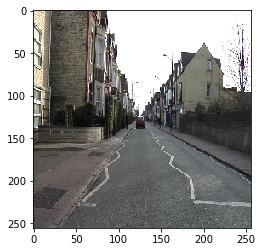

In [8]:
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(Image.fromarray(np.squeeze(train_samples_array[20])))


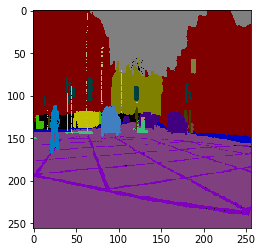

In [9]:
imshow(Image.fromarray(np.squeeze(train_labels_array[20])))

In [10]:
def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (512, 512, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 512, 512, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)

    return x

In [11]:
## normalize tensors

train_samples_array = train_samples_array.astype('float32')/255
test_samples_array = test_samples_array.astype('float32')/255 
train_labels_array = train_labels_array.astype('float32')/255
test_labels_array = test_labels_array.astype('float32') /255


In [12]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint


In [13]:
## Model for FCNNs with skip connections

img_input = Input(shape=(256,256,3))
conv1 = Conv2D(64,(3,3),activation= 'relu',padding='same')(img_input)
pool1 = MaxPool2D(pool_size=(2,2),padding='same')(conv1)

conv2 = Conv2D(128,(3,3),activation= 'relu',padding='same')(pool1)
pool2 = MaxPool2D(pool_size=(2,2),padding='same')(conv2)

conv3 = Conv2D(256,(3,3),activation= 'relu',padding='same')(pool2)
drop3 = Dropout(0.3)(conv3)
pool3 = MaxPool2D(pool_size=(2,2),padding='same')(drop3)

conv4 = Conv2D(512,(3,3),activation= 'relu',padding='same')(pool3)
drop4 = Dropout(0.3)(conv4)

# up_sample4 = UpSampling2D((2,2))(drop4)
# conv_transpose4 = Conv2DTranspose(512,(3,3),activation='relu',padding='same')(up_sample4)
# skip_connected_4 = Add()([conv_transpose4,drop4])

up_sample3 = UpSampling2D((2,2))(drop4)
conv_transpose3 = Conv2DTranspose(256,(3,3),activation='relu',padding='same')(up_sample3)
skip_connected_3 = Add()([conv_transpose3,drop3])

up_sample2 = UpSampling2D((2,2))(skip_connected_3)
conv_transpose2 = Conv2DTranspose(128,(3,3),activation='relu',padding='same')(up_sample2)
skip_connected_2 = Add()([conv_transpose2,conv2])

up_sample1 = UpSampling2D((2,2))(skip_connected_2)
conv_transpose1 = Conv2DTranspose(64,(3,3),activation='relu',padding='same')(up_sample1)
out_layer = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(conv_transpose1)

model = Model(input = img_input,output = out_layer)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

/home/aind2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [14]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Train on 422 samples, validate on 47 samples
Epoch 1/5
422/422 [==============================] - 34s 81ms/step - loss: 1.0917 - acc: 0.7372 - val_loss: 1.0633 - val_acc: 0.6610

Epoch 00001: val_loss improved from inf to 1.06326, saving model to best_weights/best_weights.hdf5
Epoch 2/5
422/422 [==============================] - 27s 63ms/step - loss: 1.0550 - acc: 0.6386 - val_loss: 1.0558 - val_acc: 0.6553

Epoch 00002: val_loss improved from 1.06326 to 1.05582, saving model to best_weights/best_weights.hdf5
Epoch 3/5
422/422 [==============================] - 27s 63ms/step - loss: 1.0518 - acc: 0.6328 - val_loss: 1.0603 - val_acc: 0.6191

Epoch 00003: val_loss did not improve from 1.05582
Epoch 4/5
422/422 [==============================] - 27s 64ms/step - loss: 1.0497 - acc: 0.6337 - val_loss: 1.0627 - val_acc: 0.7206

Epoch 00004: val_loss did not improve from 1.05582
Epoch 5/5
422/422 [==============================] - 27s 64ms/step - loss: 1.0476 - acc: 0.6363 - val_loss: 1.0570 

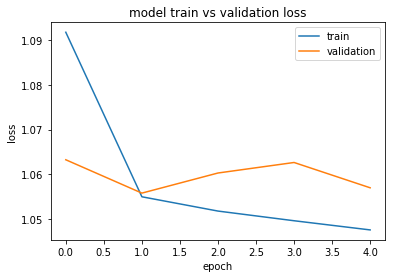

In [15]:
check_pointer = ModelCheckpoint('best_weights/best_weights.hdf5',verbose=1,save_best_only=True)
history = model.fit(train_samples_array,train_labels_array,epochs=5,verbose=1,validation_split=0.1, batch_size=5,callbacks=[check_pointer])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
# model.fit(train_samples_array,train_labels_array,epochs=5,verbose=2,batch_size=5,validation_split=0.2,callbacks=[check_pointer])

In [17]:
test_metrics = model.evaluate(test_samples_array,test_labels_array)

print(test_metrics)

232/232 [==============================] - 8s 34ms/step
[1.0471121401622379, 0.6121919566187365]


In [33]:
pred_array = model.predict(np.expand_dims(train_samples_array[20],axis=0))
label_array =  train_labels_array[20]

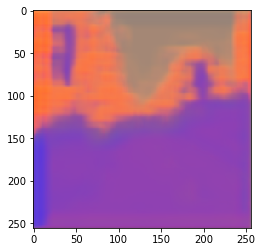

In [34]:
imshow(Image.fromarray(np.squeeze((pred_array*255).astype('uint8'))))



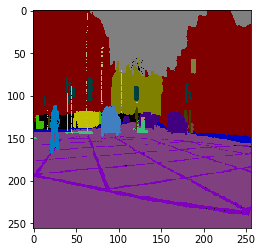

In [35]:
imshow(Image.fromarray(np.squeeze((label_array*255).astype('uint8'))))
# Image.fromarray(np.squeeze((label_array).astype('uint8')))